# Data Loading and Preprocessing 
---

This notebook will handle the preprocessing of the data that will be used in the master thesis.

**Contents:**
1. [Extracting the data from the Cognite API](#data-extraction)
2. [Handling missing data (NA)](#na-handling)
3. [Handling outliers/anomalies](#outlier-handling)
4. [Data scaling by standardisation](#data-scaling)
5. [Splitting the data into training, validation and testing sets](#data-splitting)
6. [Exporting the data](#saving)

In [2]:
%reset -f 
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from datetime import datetime

from cognite.client import CogniteClient

In [3]:
# define global root path
ROOT_PATH = os.path.abspath(".").split("src")[0]

# set plot settings
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)

Authenticate session with the Cognite SDK using the CogniteClient with the retrieved API key

In [4]:
client = CogniteClient(api_key=os.environ['COGNITE_API_SECRET'])

---
## Notebook parameters <a class="anchor" id="notebook-parameters"></a>

In [5]:
START = datetime(2017,12, 24)  ## the start date of the asset time series interval
END = datetime(2018, 2, 24)    ## the end date of the asset time series interval 
TIME_INTERVAL_MINUTES = 1      ## the minutes between each reading in the time series
GRANULARITY = str(TIME_INTERVAL_MINUTES) + 'm' ## the string representation of TIME_INTERVAL_MINUTES
AGGREGATES = ['average']       ## the aggregates to extract from the Cognite API

NA_THRESHOLD = 2.5             ## the threshold percentage which filters relevant assets
TAU = 5.0                      ## the threshold that seperates outliers from normal data

TRAIN_PERCENTAGE = 0.6         ## percentage of observations to include in the training set
VALID_PERCENTAGE = 0.2         ## percentage of observations to include in the validation set
TEST_PERCENTAGE = 1.0 - TRAIN_PERCENTAGE - VALID_PERCENTAGE

TAGS_PREDICTORS = pd.read_csv(ROOT_PATH+"data/metadata/tags_predictors.csv", 
                              sep=";", keep_default_na=False, header=None).values[:,0]

TAGS_TARGETS = pd.read_csv(ROOT_PATH+"data/metadata/tags_targets.csv", 
                           sep=";", keep_default_na=False, header=None).values[:,0]

TAGS_ALL = np.append(TAGS_TARGETS, TAGS_PREDICTORS)

---
# (1) Extracting assets and time series from the Cognite API 
<a class="anchor" id="data-extraction"></a>

We use the Python SDK from Cognite to extract time series about the assets. We extract data from all 320 available tags, which are defined in `data/metadata/tags_*`. 

---

In [6]:
def read_data(tags, start=START, end=END, granularity=GRANULARITY, aggregates=AGGREGATES):
    """
    Extract time series from the Cognite API given a list of tags.
    
    Args: 
        tags ([String]): A list of tags to extract time series of.
        start (datetime): A datetime object specifying the start of the interval
        end (datetime): A datetime object specifying the end of the interval
        granularity (String): Time between two samplings
        aggregates ([String]): Data properties to extract
    
    Returns: 
        pd.DataFrame: The dataframe of tags data
    """
    
    data = client.datapoints.get_datapoints_frame(list(tags), 
                                                  start=start, 
                                                  end=end, 
                                                  granularity=granularity, 
                                                  aggregates=aggregates)
    
    columns = [name.split("|")[0] for name in data.columns]
    data.columns=columns
    
    return data


def load_predictor_data(timestamps, tags=TAGS_PREDICTORS):
    """
    Load data for the predictor tags. 
    Cognite API has limit for 100 assets at a time, so must create fetch intervals.
    """
    data_predictors = pd.DataFrame(timestamps, columns=["timestamp"])
    intervals = np.arange(0,len(tags),100)

    if intervals[-1] != len(tags):
        intervals = np.append(intervals, len(tags))

    for i, j in enumerate(intervals[1:]):
        from_int = intervals[i]
        to_int = j

        tmp_tags = list(tags[from_int:to_int])
        tmp_data = read_data(tmp_tags)      

        data_predictors = data_predictors.join(tmp_data.set_index("timestamp"), on="timestamp")
        print("-- Completed tags {0} to {1}".format(from_int, to_int))
    
    return data_predictors

In [7]:
# read the targets data
print("Retrieving targets data...")
data_targets = read_data(TAGS_TARGETS, START, END, GRANULARITY, AGGREGATES)
print("*---------------------------*")
print("Number of observations:", len(data_targets))
print("Number of targets:     ", data_targets.shape[1]-1)

# read the predictors data
print("\nRetrieving predictors data...")
data_predictors = load_predictor_data(timestamps=data_targets.timestamp, tags=TAGS_PREDICTORS)
print("*---------------------------*")
print("Number of observations:", len(data_predictors))
print("Number of predictors:  ", data_predictors.shape[1]-1)

# do some tests to ensure that all tags are included
assert len(data_targets) == len(data_predictors)
assert TAGS_TARGETS[0] == data_targets.columns[1] and TAGS_TARGETS[-1] == data_targets.columns[-1]
assert TAGS_PREDICTORS[0] == data_predictors.columns[1] and TAGS_PREDICTORS[-1] == data_predictors.columns[-1]
assert data_predictors.shape[1] == len(TAGS_PREDICTORS)+1
assert len(np.unique(data_predictors.columns)) == len(data_predictors.columns)

# extract the timestamp column
TIMESTAMPS = data_targets.timestamp
DTIMESTAMPS = pd.to_datetime(TIMESTAMPS,unit="ms")

# concatenate the targets and predictors to a full dataframe
data_full = data_targets.join(data_predictors.set_index("timestamp"), on="timestamp")

# drop the timestamp column from the dataframes
data_targets = data_targets.drop(columns=['timestamp']) 
data_predictors = data_predictors.drop(columns=['timestamp']) 
data_full = data_full.drop(columns=['timestamp'])

print(data_targets.shape, data_predictors.shape, data_full.shape)

Retrieving targets data...
*---------------------------*
Number of observations: 88685
Number of targets:      3

Retrieving predictors data...
-- Completed tags 0 to 100
-- Completed tags 100 to 200
-- Completed tags 200 to 300
-- Completed tags 300 to 317
*---------------------------*
Number of observations: 88685
Number of predictors:   317
(88685, 3) (88685, 317) (88685, 320)


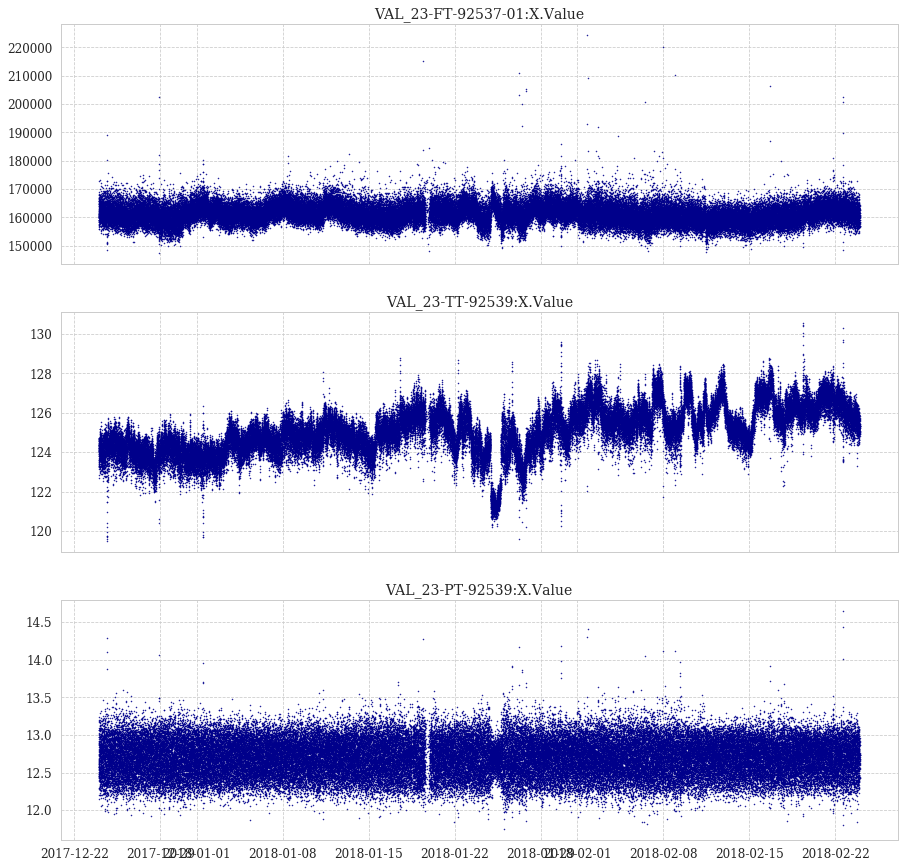

In [8]:
# plot targets
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize = (15,15))
for i, tag in enumerate(TAGS_TARGETS):
    ax = axs[i]
    ax.plot_date(DTIMESTAMPS, data_targets[tag], color="darkblue", markersize=0.5, marker="o")
    ax.set_title(tag)

fig.show()

---

# (2) Handling NA values and missing data
<a class="anchor" id="na-handling"></a>

The data contains missing data. The NA values must be removed from each column before the data can be used. First, an analysis of the NA data is done. Thereafter, the NA values are handled in the following ways: 
- The assets with relative high sparsity are simply removed from the dataset
- For each NA observation, if there exists a value before and after it, its value is set to the average of the preceding and the next value. 
- For the remaining NA data, the _Amelia_ algorithm is used to impute the values. 

---

First, an analysis of the NA in the datasets:

In [9]:
def get_stats_properties(data, include_nans=True):
    """
    Get the statistical properties of a pandas dataframe
    
    Args: 
        data (pandas.DataFrame): Data to analyse properties of
    
    Returns:
        pandas.DataFrame: Dataframe with statistical properties of the input data
    """
    dfmeans = data.mean().tolist()
    dfmedians = data.median().tolist()
    dfstds = data.std().tolist()
    dfmaxs = data.max().tolist()
    dfmins = data.min().tolist()
    dfdiff_maxmin = np.subtract(dfmaxs,dfmins)
    dfquantiles = data.quantile([.25,.75])
    dfq1 = dfquantiles.iloc[0,:].tolist()
    dfq3 = dfquantiles.iloc[1,:].tolist()
    
    stats_matr = [dfmeans,dfmedians,dfstds,dfmaxs,dfmins,dfq1,dfq3]
    stat_cols = ["Mean", "Median", "Std", "Max", "Min", "1st Qu.", "3rd Qu."]
    
    if include_nans:
        nas = data.isna().sum().tolist()
        stats_matr.append(nas)
        stat_cols.append("NAs")
        
    return pd.DataFrame(np.array(stats_matr).T, index=data.columns, columns=stat_cols)

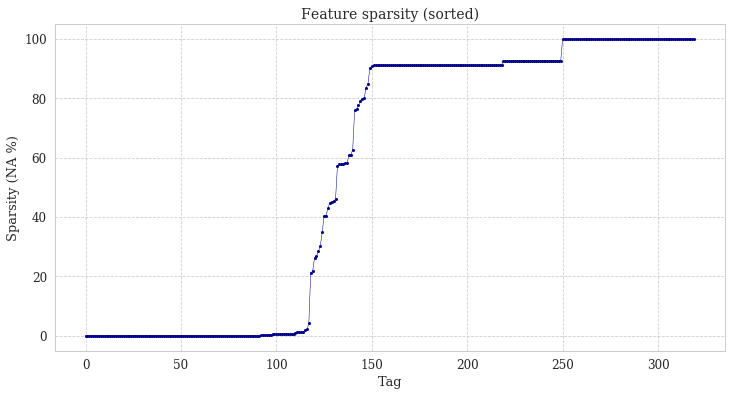

Mean         Median          Std  \
VAL_23-FT-92537-01:X.Value    161417.157637  161285.910090  3451.291254   
VAL_23-TT-92539:X.Value          125.079347     125.064337     1.183979   
VAL_23-PT-92539:X.Value           12.698143      12.702663     0.245375   
VAL_23-ESDV-92501A-PST:VALUE       0.000000       0.000000     0.000000   
VAL_23-ESDV-92501B-PST:VALUE       0.000000       0.000000     0.000000   

                                        Max            Min        1st Qu.  \
VAL_23-FT-92537-01:X.Value    224396.129479  147442.173910  159105.709228   
VAL_23-TT-92539:X.Value          130.570725     119.512739     124.280447   
VAL_23-PT-92539:X.Value           14.656747      11.752882      12.518977   
VAL_23-ESDV-92501A-PST:VALUE       0.000000       0.000000       0.000000   
VAL_23-ESDV-92501B-PST:VALUE       0.000000       0.000000       0.000000   

                                    3rd Qu.      NAs  
VAL_23-FT-92537-01:X.Value    163550.644406     18.0  
VAL_23-TT-92539:X.Value          125.882580   1227.0  
VAL_23-PT-92539:X.Value           12.875018     21.0  
VAL_23-ESDV-92501A-PST:VALUE       0.000000  80888.0  
VAL_23-ESDV-92501B-PST:VALUE       0.000000  80888.0

In [42]:
stats = get_stats_properties(data=data_full)

# plot the NAs per tag
plt.figure()
plt.plot(100*stats.sort_values(by="NAs")["NAs"].values/len(data_full), ms=2.0, marker="o", ls="-", lw=0.5, c="darkblue")
plt.title("Feature sparsity (sorted)")
plt.xlabel("Tag")
plt.ylabel("Sparsity (NA %)")
plt.show()

stats.head(5)

**Removing high-sparsity features**

We see that most of the tags have a high sparsity, meaning that they have a high percentage of NAs in their readings. We remove the high-sparsity tags by setting a threshold. According to the plot, this is approximately at tag 115-120. The "NA threshold percentage" decides the maximum allowed sparsity of a feature. 

In [49]:
# choose tags to keep
data_na=data_full.loc[:,stats["NAs"] <= len(data_full)*NA_THRESHOLD/100]

# make sure that the target tags are still included
assert np.all(data_na.columns[:3] == list(TAGS_TARGETS))
assert np.all(data_na.isna().sum().values <= len(data_full)*NA_THRESHOLD/100)

# print the stats columns
get_stats_properties(data=data_na).head(5)
print("Number of tags after filtering:", data_na.shape[-1])
print("Average sparsity (NA %): {0}%".format(round(100*np.average(data_na.isna().sum().values/len(data_na)),3)))

Number of tags after filtering: 117
Average sparsity (NA %): 0.177%


### Handling missing data

In order to handle the missing data, we do the following: 
- When the preceding and succeeding values exist, the missing value is imputed linearly (the average of the preceding and the succeeding values).
- The remaining NA values are imputed by the Amelia algorithm

**Linear imputation**

In [66]:
## If the value exists before and after, then impute it linearly
data_imp = data_na.copy()

for col in range(data_imp.shape[-1]):
    idxs = np.where(data_imp.iloc[:,col].isna())[0]
    for idx in idxs: 
        
        # if the index is the first or last, continue
        if idx == 0 or idx == len(data_na):
            continue
        
        curr_val = data_imp.iloc[idx, col]
        next_val = data_imp.iloc[idx+1, col]
        last_val = data_imp.iloc[idx-1, col]
        
        # if value is 
        if np.isnan(curr_val) and not np.isnan(last_val) and not np.isnan(next_val):
            data_imp.iloc[idx,col] = np.average([last_val, next_val])

new_percentage = round(100*np.average(data_imp.isna().sum().values/len(data_imp)),3)
old_percentage = round(100*np.average(data_na.isna().sum().values/len(data_na)),3)
print("New sparsity: {}%, ".format(new_percentage) + 
      "Old sparsity: {}%, ".format(old_percentage) + 
      "Improvement: {}%".format(round(1-new_percentage/old_percentage,3)))

get_stats_properties(data=data_imp).head(5)

New sparsity: 0.075%, Old sparsity: 0.177%, Improvement: 0.576%


Mean         Median          Std  \
VAL_23-FT-92537-01:X.Value  161417.151479  161285.897240  3451.246477   
VAL_23-TT-92539:X.Value        125.080403     125.066368     1.183835   
VAL_23-PT-92539:X.Value         12.698141      12.702644     0.245368   
VAL_23-FT-92512:X.Value      98389.558110   99721.391043  8799.594023   
VAL_23-FT-92521:X.Value          3.798062       4.043526     0.871534   

                                      Max            Min        1st Qu.  \
VAL_23-FT-92537-01:X.Value  224396.129479  147442.173910  159105.709228   
VAL_23-TT-92539:X.Value        130.570725     119.512739     124.282265   
VAL_23-PT-92539:X.Value         14.656747      11.752882      12.518985   
VAL_23-FT-92512:X.Value     216656.494867   36485.961863   93326.384333   
VAL_23-FT-92521:X.Value         10.354373       0.003534       3.639982   

                                  3rd Qu.     NAs  
VAL_23-FT-92537-01:X.Value  163550.644406    14.0  
VAL_23-TT-92539:X.Value        125.883848   105.0  
VAL_23-PT-92539:X.Value         12.875013    12.0  
VAL_23-FT-92512:X.Value     104479.715896    17.0  
VAL_23-FT-92521:X.Value          4.301171  1142.0

**Imputing remaining NA with Amelia**

Next, we use the Amelia algorithm to impute the remaining NA values. Amelia is an R package for the multiple imputation of incomplete data. Multiple imputation is a method to overcome the computational problem of missing data while maintaining good statistical properties. Multiple imputation involves imputing m values for each missing cell in your data matrix and creating m "completed" data sets. (Across these completed data sets, the observed values are the same, but the missing values are filled in with different imputations that reflect our uncertainty about the missing data.) After imputation, Amelia will then save the m data sets.

In [78]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [79]:
%%R -i data_imp -w 5 -h 5 --units in -r 200

# install.packages(c("Amelia", "stringr"))  ## uncomment if you need to install the libraries
library(Amelia)
library(stringr)

print(sum(is.na(data_imp)))
amelia.data <- amelia(data_imp, m = 1, parallel = "multicore")

imput <- 1
am.data <- amelia.data$imputations[[imput]]
print(sum(is.na(am.data)))
percentage_na <- round(sum(is.na(am.data)) / nrow(am.data),2)
cat(str_glue('Percentage NAs: {percentage_na}%'), '\n')

# write to file
write.table(
    am.data, 
    "../../data/amelia_data.csv",
    row.names = FALSE,
    sep = ","
)

[1] 7826
-- Imputation 1 --

  1  2  3  4

[1] 0
Percentage NAs: 0% 


In [80]:
# read the data
path=ROOT_PATH+"data/amelia_data.csv"
data_amelia = pd.read_csv(path, sep=",")

data_amelia.columns = data_imp.columns

# if not all columns have 0 NA, use forward filling
if not np.all(data_amelia.isna().sum() == 0):
    data_amelia = data.fillna(method="ffill")
    data_amelia = data.fillna(method="backfill")

assert np.all(data_amelia.isna().sum() == 0)

# delete the data file
os.remove(path)

---
# (3) Handling exisiting anomalies and outliers from the dataset
<a class="anchor" id="outlier-handling"></a>

---
Faulty data can stem from multiple sources:
- Error/Noise in the sensor readings
- Actual faulty data

Faulty data is a problem for mainly these reasons: 
- We want to train a model on the normal behaviour of the compressor. Existing faulty behaviour must therefore be handled in some say, so that our model doesn't learn anomalous behaviour as normal behaviour.
- Outliers and extreme values has a large impact on how the data is scaled because it largely affect data parameters such as mean and variance. 

In effect, the faulty data can drastically bias the precision of our models. In order to avoid this we need to identify and act on the existing anomalies. 

As we're dealing with unsupervised anomaly detection, we do not have any labeled regions of faulty or healthy data. As a result, we must find alternative ways to spot the outliers in the dataset. Here, we set a fixed threshold ${\tau}$ that labels a datapoint as an extreme value or not. The procedure goes as follows: 
- We define a threshold $\tau$
- Any observation $x$ such that $\left\lvert Z(x) \right\rvert = \frac{x - \mu}{\sigma} \gt \tau$ is considered an extreme value or an anomaly. These values are set to undefined (or "NaN").
- The values are then imputed using the R-package Amelia. 
- If Amelia for some reason doesn't impute _all_ the NAs, then forward and backwards- filling is used. 

First, let's see what points are defined as "extremes" or "outliers" in our existing targets:

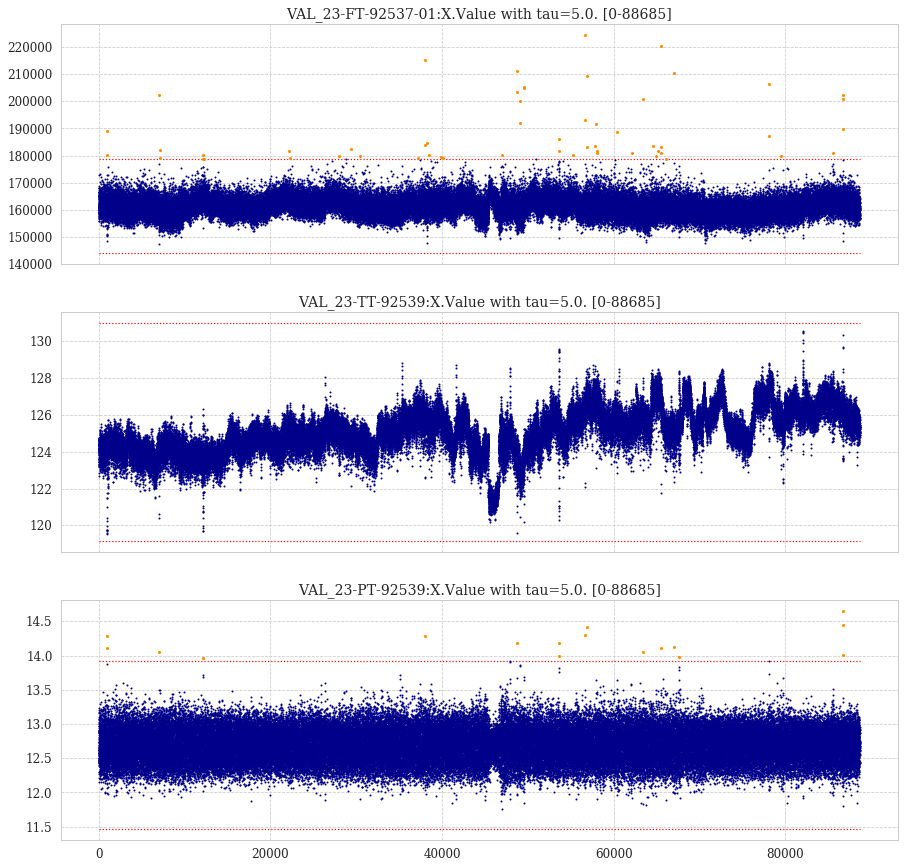

In [81]:
def plot_tau_lims(data, tau=TAU):
    """
    Plots the input data with Z thresholds given by tau. 
    
    Args: 
        data (pandas.DataFrame): The data to plot
        tau (float): The threshold of Z 
        
    Returns: 
        nothing, but shows a plt.subplot
    """
    
    data_means = data.mean().values
    data_stds = data.std().values

    plot_from, plot_length=0, 100000
    plot_to = min(plot_from+plot_length,len(data))
    
    fig, axs = plt.subplots(nrows=data_targets.shape[-1], ncols=1, sharex=True, figsize = (15,15))
    for col in (range(data_targets.shape[-1])):
        tmp_data = data.iloc[plot_from:plot_to, col].values
        z_values = (tmp_data - data_means[col])/data_stds[col]
        idxs_outside = np.where(np.abs(z_values) > tau)[0]
        idxs_within = np.where(np.abs(z_values) <= tau)[0]

        data_within_lims = tmp_data[idxs_within]
        data_outside_lims = tmp_data[idxs_outside]
        
        ax = axs[col]
        ax.plot(idxs_within, data_within_lims, color="darkblue", marker="o", ms=1.0, lw=0)
        ax.plot(idxs_outside, data_outside_lims, color="darkorange", marker="o", ms=2.0, lw=0)
        ax.hlines(y=data_means[col]-data_stds[col]*tau, xmin=0, 
                   xmax=len(data), linestyle="dotted", color="red")
        ax.hlines(y=data_means[col]+data_stds[col]*tau, xmin=0, 
                   xmax=len(data), linestyle="dotted", color="red")
        ax.set_title("{0} with tau={1}. [{2}-{3}]".format(TAGS_TARGETS[col], tau, plot_from, plot_to))
    fig.show()

plot_tau_lims(data=data_amelia, tau=TAU)

Now, let's set all the outliers as "undefined" using the `impute_nan()`-function. Thereafter, Amelia is used to recalculate the most likely values of the extremes. 

In [84]:
def impute_nan(data, tau=TAU):
    """
    Set observations with abs(Z(x))>tau to NaN
    
    Args: 
        data (pandas.DataFrame): data to impute
        tau (afloat): threshold value
    
    Returns:
        pandas.DataFrame: the imputed dataset
    """
    
    data_imputed = data.copy()
    data_means = data.mean().values
    data_stds = data.std().values

    for col in (range(data.shape[-1])):       
        # compute z_values for each observation
        z_values = (data.iloc[:,col] - data_means[col])/data_stds[col]
        
        # find idxs exceeding threshold
        idxs = np.where(np.abs(z_values) > tau)[0]
        
        # impute with np.NaN
        data_imputed.iloc[idxs,col] = np.nan
    
    return data_imputed

data_amelia_nan = impute_nan(data=data_amelia, tau=5)
print("# NA in data_amelia:      ", np.sum(data_amelia.isna().sum()))
print("# NA in data_amelia_nan:  ", np.sum(data_amelia_nan.isna().sum()))

# NA in data_amelia:       0
# NA in data_amelia_nan:   8758


In [86]:
%%R -i data_amelia_nan -w 5 -h 5 --units in -r 200

# install.packages(c("Amelia", "stringr"))  ## uncomment if you need to install the libraries
library(Amelia)
library(stringr)

print(sum(is.na(data_amelia_nan)))
amelia.data <- amelia(data_amelia_nan, m = 1, parallel = "multicore")

imput <- 1
am.data <- amelia.data$imputations[[imput]]
print(sum(is.na(am.data)))
percentage_na <- round(sum(is.na(am.data)) / nrow(am.data),2)
cat(str_glue('Percentage NAs: {percentage_na}%'), '\n')

# write to file
write.table(
    am.data, 
    "../../data/amelia_data.csv",
    row.names = FALSE,
    sep = ","
)

[1] 8758
-- Imputation 1 --

  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18

[1] 0
Percentage NAs: 0% 


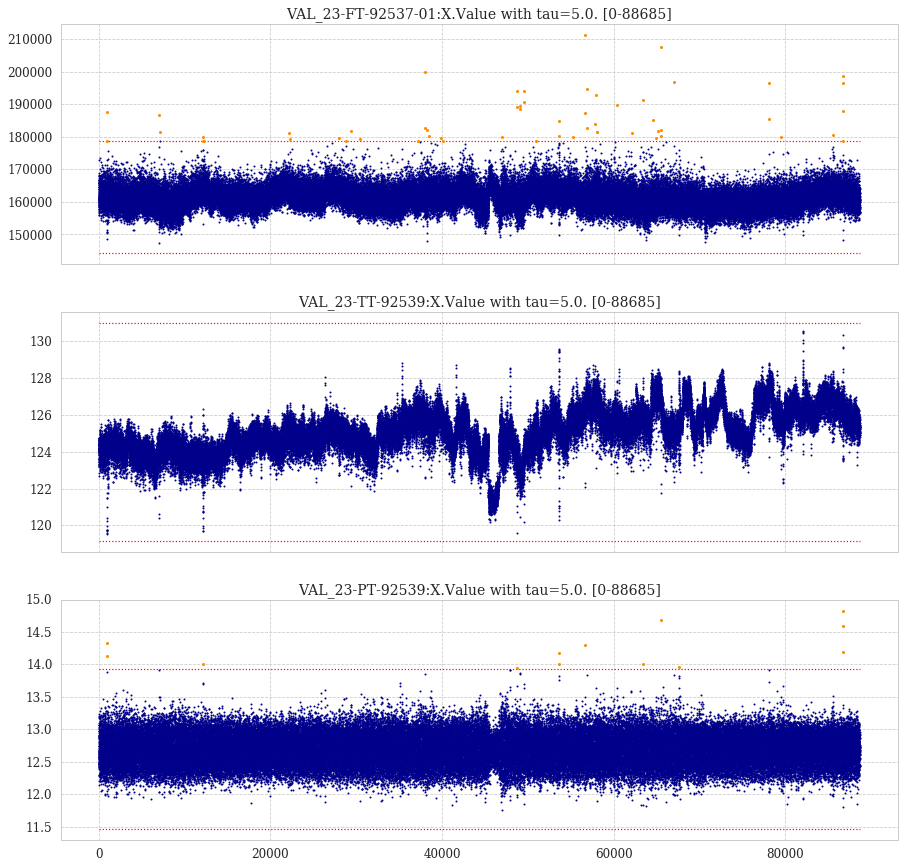

In [87]:
# read the data
path=ROOT_PATH+"data/amelia_data.csv"
data_amelia_nan = pd.read_csv(path, sep=",")

data_amelia_nan.columns = data_amelia.columns

# if not all columns have 0 NA, use forward filling
if not np.all(data_amelia_nan.isna().sum() == 0):
    data_amelia = forward_fill(data_amelia_nan)
assert np.all(data_amelia_nan.isna().sum() == 0)

# delete the data file
os.remove(path)

plot_tau_lims(data_amelia_nan)

---
# (4) Data scaling
<a class="anchor" id="data-scaling"></a>

---
There are essentially two common ways to scale the data: 
1. Standardisation
    - Transforming the data to zero mean and unit variance
2. Normalisation
    - Transforming the data column-wise between 0 and 1 such that the max value is set to 1 and the minimum value to 0.

Here we'll go for option 1: Standardisation.

In addition, **data snooping** is a concern that must be considered. Important that the data is scaled according to the data in the **training set** and *not* the data included in the validation and the testing set here. In essence, everything that's learnt must be learnt from the training set, and we pretend to know nothing about the validation and testing set.  

In [89]:
data_imputed = data_amelia_nan

train_size = int(TRAIN_PERCENTAGE * len(data_imputed))
valid_size = int(VALID_PERCENTAGE * len(data_imputed))
test_size = len(data_imputed) - train_size - valid_size

In [90]:
def plot_scale_comparison(data,data_scaled,timestamps=DTIMESTAMPS, target=0):
    """
    Function to plot the comparison between scaled and unscaled data
    """
    inds = np.arange(1000,1400,5)

    fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax1.plot_date(timestamps[inds], data[inds,target], linewidth=1.0, linestyle="-", color="darkblue")
    ax1.set_title("Unscaled {0}".format(TAGS_TARGETS[target]))
    ax2.plot_date(DTIMESTAMPS[inds], data_scaled[inds,target], linewidth=1.0, linestyle="-", color="darkred")
    ax2.set_title("Scaled {0}".format(TAGS_TARGETS[target]))
    plt.show()

## (4.1) Scaling by standardisation

====== SCALING BY STANDARDIZATION ======


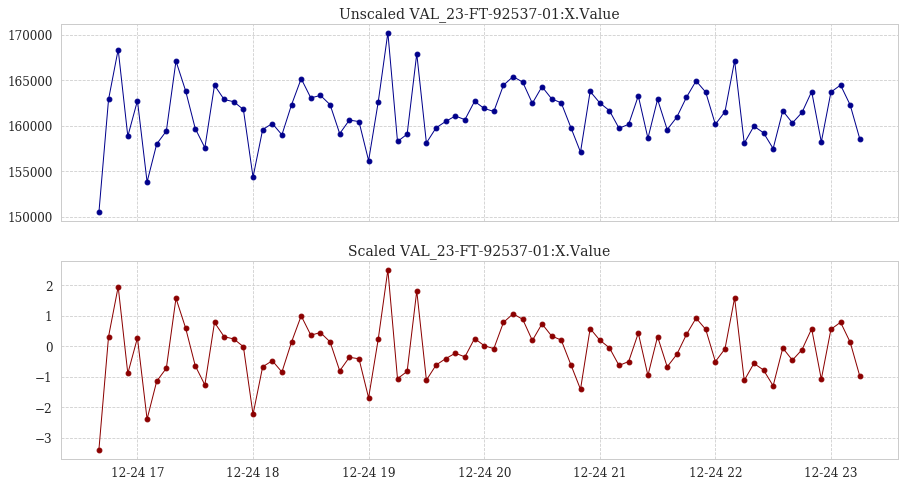

Mean    Median  Std        Max       Min  \
VAL_23-FT-92537-01:X.Value  4.057145e-13 -0.039271  1.0  11.333665 -4.281568   
VAL_23-TT-92539:X.Value     7.287434e-13  0.021753  1.0   4.409773 -5.103244   
VAL_23-PT-92539:X.Value    -5.186014e-14  0.010381  1.0   6.569205 -3.817090   
VAL_23-FT-92512:X.Value    -4.427015e-14  0.084520  1.0   4.346567 -4.868986   
VAL_23-FT-92521:X.Value     3.175980e-14  0.300718  1.0   3.617445 -4.135083   

                             1st Qu.   3rd Qu.  NAs  
VAL_23-FT-92537-01:X.Value -0.671688  0.628476  0.0  
VAL_23-TT-92539:X.Value    -0.586772  0.648934  0.0  
VAL_23-PT-92539:X.Value    -0.734882  0.720795  0.0  
VAL_23-FT-92512:X.Value    -0.540673  0.676477  0.0  
VAL_23-FT-92521:X.Value    -0.209855  0.587905  0.0

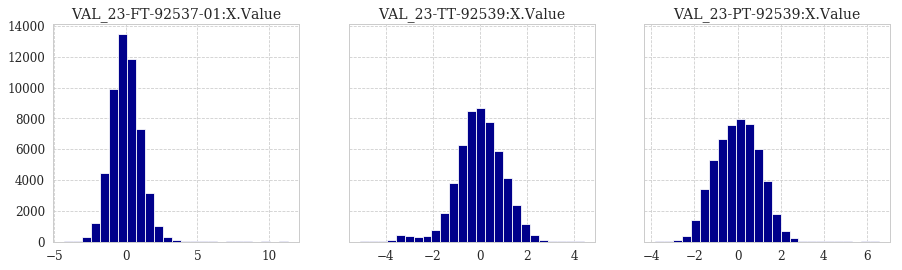

In [91]:
means = data_imputed[:train_size].mean().tolist()
stds = data_imputed[:train_size].std().tolist()

data_scaled = data_imputed.copy()
data_scaled -= means
data_scaled /= stds

print("====== SCALING BY STANDARDIZATION ======")
plot_scale_comparison(data=data_imputed.values, data_scaled=data_scaled.values)

fig, axs = plt.subplots(nrows=1, ncols=len(TAGS_TARGETS), sharey=True, figsize = (15,4))
for i in range(len(TAGS_TARGETS)):
    target = TAGS_TARGETS[i]
    ax = axs[i]
    
    ax.hist(data_scaled.values[:train_size,i], bins=25, color="darkblue")
    ax.set_title(target)
fig.show()

get_stats_properties(data_scaled[:train_size]).head()

---
# (5) Splitting into a training, validation and testing sets
<a class="anchor" id="data-splitting"></a>

---

In [92]:
data_train = data_scaled[:train_size]
data_valid = data_scaled[train_size:train_size+valid_size]
data_test = data_scaled[-test_size:]

print(data_train.shape, data_valid.shape, data_test.shape)

(53211, 117) (17737, 117) (17737, 117)


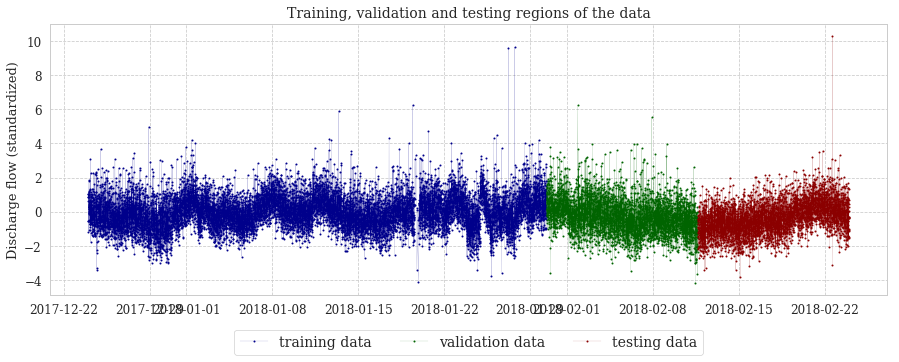

In [93]:
# plot the regions for a feature
target = 0 # the flow
delta = 5

plt.figure(figsize=(15,5))

# training data
plt.plot(DTIMESTAMPS[:train_size:delta], 
         data_train.values[::delta, target], 
         marker="o", ms=1, lw = 0.1, c="darkblue", ls="-", label="training data")

# validation data
plt.plot(DTIMESTAMPS[train_size:-test_size:delta], 
         data_valid.values[::delta, target],  
         marker="o", ms=1, lw = 0.1, c="darkgreen", ls="-", label="validation data")

# testing data
plt.plot(DTIMESTAMPS[-test_size::delta], 
         data_test.values[::delta, target],  
         marker="o", ms=1, lw = 0.1, c="darkred", ls="-", label="testing data")

plt.ylabel("Discharge flow (standardized)")
plt.legend(frameon=True, loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=3)
plt.title("Training, validation and testing regions of the data")
plt.show()

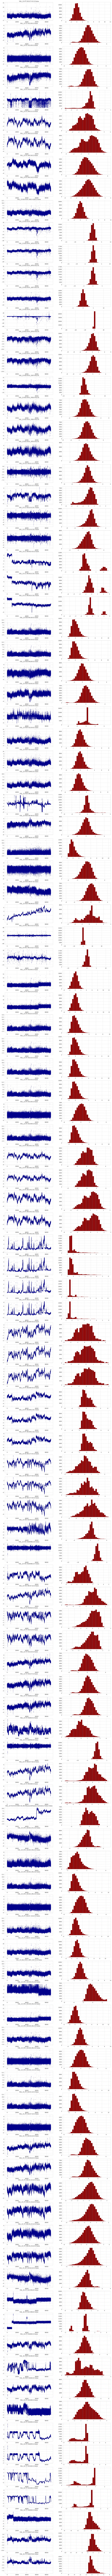

In [94]:
fig, axs = plt.subplots(nrows=int(data_scaled.shape[-1]), ncols=2, figsize=(20,500))
f = 0
for figrow in range(data_scaled.shape[-1]):
    ax1,ax2 = axs[figrow,0], axs[figrow,1]
    
    ax1.plot(data_scaled.iloc[:,f], color="darkblue",
            marker="o", markersize=1.0, lw=0)
    ax1.set_title(data_scaled.columns[f])
    
    ax2.hist(data_scaled.iloc[:train_size,f], bins=30, color="darkred")
    f +=1

fig.show()

---
# (6) Save the data to files
<a class="anchor" id="saving"></a>

Finally, the datasets are exported to .npy-files so that they can be further processed.

---

In [102]:
# raw data files
#### path = ROOT_PATH + "data/raw/"
#### np.save(path + "data_raw_full.npy", data_full.values)
#### np.save(path + "data_raw_targets.npy", data_targets.values)
#### np.save(path + "data_raw_predictors.npy", data_predictors.values)

# scaled data files
path = ROOT_PATH + "data/scaled/"
np.save(path + "data_scaled_full.npy", data_scaled.values)
np.save(path + "data_scaled_train.npy", data_train.values)
np.save(path + "data_scaled_valid.npy", data_valid.values)
np.save(path + "data_scaled_test.npy", data_test.values)

# metadata
path = ROOT_PATH + "data/metadata/"

np.save(path + "timestamps.npy", TIMESTAMPS.values)
np.save(path + "date_timestamps.npy", DTIMESTAMPS.values)
np.save(path + "ts_train.npy", DTIMESTAMPS[:train_size].values)
np.save(path + "ts_valid.npy", DTIMESTAMPS[train_size:-test_size].values)
np.save(path + "ts_test.npy", DTIMESTAMPS[-test_size:].values)

pd.Series(data_scaled.columns).to_csv(path+"tags_all_chosen.csv", index=False)

np.save(path + "means.npy", means)
np.save(path + "stds.npy", stds)

In [103]:
# make a dummy dataset of a few first observations
num_obs = [5000,10000,25000]
for n in num_obs: 
    dum_trainsize = int(0.6 * n)
    dum_validsize = int(0.2 * n)
    dum_testsize = n - (dum_trainsize + dum_validsize)

    dummy_train = data_train.values[:dum_trainsize]
    dummy_valid = data_valid.values[:dum_validsize]
    dummy_test = data_test.values[:dum_testsize]
    
    dummy_data = np.concatenate((dummy_train,dummy_valid,dummy_test),axis=0)

    print("Saving dummy files with num obs =",n)
    print(dummy_train.shape, dummy_valid.shape, dummy_test.shape)

    np.save(ROOT_PATH + "data/scaled/dummy/dummy_complete_{0}.npy".format(n), dummy_data)
    np.save(ROOT_PATH + "data/scaled/dummy/dummy_train_{0}.npy".format(n), dummy_train)
    np.save(ROOT_PATH + "data/scaled/dummy/dummy_valid_{0}.npy".format(n), dummy_valid)
    np.save(ROOT_PATH + "data/scaled/dummy/dummy_test_{0}.npy".format(n), dummy_test)
    print()

Saving dummy files with num obs = 5000
(3000, 117) (1000, 117) (1000, 117)

Saving dummy files with num obs = 10000
(6000, 117) (2000, 117) (2000, 117)

Saving dummy files with num obs = 25000
(15000, 117) (5000, 117) (5000, 117)

